In [29]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.externals import joblib

%matplotlib inline

pandas.set_option("display.precision", 2)


%store -r WORKDIR

if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/BZ241WX/Documents/InfNet/CursoPosDataScience/mit_data_science/'

input_table = WORKDIR + '/Data/Processed/winequality-red-proc.parquet'

model_file = WORKDIR + '/Data/Modeling/wine_model.jbl'
save_data =  WORKDIR + '/Data/Modeling/dev_results.jbl'

target_variable = 'good_quality'
classifier_variables = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
                        'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Leitura dos dados

In [2]:
data = pandas.read_parquet(input_table)
print('data shape:', data.shape)
print('data columns:', data.columns.tolist())

data shape: (1279, 13)
data columns: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'name', 'good_quality']


# Validação Cruzada

In [3]:
X = data[classifier_variables].values
Y = data[target_variable].values
classes=['baixa qualidade','alta qualidade']

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,
                                                                Y,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=Y)

# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0)

# Random Forest

In [21]:
# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', ensemble.RandomForestClassifier()),
]
model_pipe = pipeline.Pipeline(conf_train_pipe)

# Grid-Search
param_grid = {
    'Model__n_estimators': [10, 30, 40],
    'Model__max_depth': [4, 6, 8],
}
model_pipe = model_selection.GridSearchCV(model_pipe,
                                          param_grid,
                                          scoring=None,
                                          fit_params=None,
                                          cv=cvfold)

model_pipe.fit(Xtrain, Ytrain)


decision_threshold = 0.5
Yhat = model_pipe.predict_proba(Xtest)[:,1]
Ypred= Yhat >= decision_threshold

print('Yhat.shape:', Yhat.shape)


joblib.dump({'model': model_pipe,
             'variables': classifier_variables},
            model_file)

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Yhat.shape: (256,)


['C:/Users/BZ241WX/Documents/InfNet/CursoPosDataScience/mit_data_science//Data/Modeling/wine_model.jbl']

# Export Development Data 

In [55]:
data.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'name', 'good_quality',
       'estimated_score'],
      dtype='object')

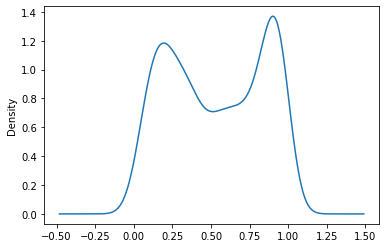

In [30]:
Ydev = model_pipe.predict_proba(data[classifier_variables].values)[:,1]
data['estimated_score'] = Ydev
data.to_parquet(save_data)
data.estimated_score.plot.kde()

## Distribuição

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Taxa de Detecção')

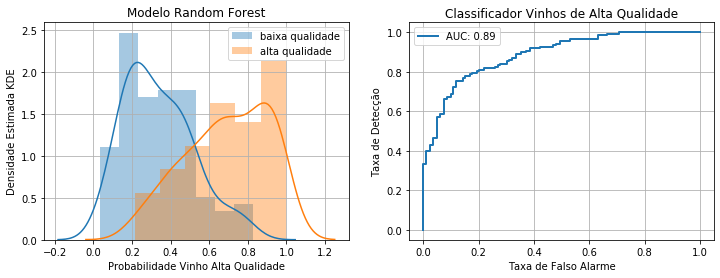

In [5]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.distplot(Yhat[~Ytest], label=classes[0])
sns.distplot(Yhat[ Ytest], label=classes[1])

plt.title('Modelo Random Forest')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Vinho Alta Qualidade')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
auc = metrics.roc_auc_score(Ytest, Yhat)
plt.plot(fpr, tpr, '-', lw=2, label='AUC: %.2f'%(auc))
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

# Relatório de Classificação 

In [6]:
print(metrics.classification_report(Ytest, Ypred, target_names=classes))

                 precision    recall  f1-score   support

baixa qualidade       0.77      0.83      0.80       119
 alta qualidade       0.84      0.79      0.82       137

      micro avg       0.81      0.81      0.81       256
      macro avg       0.81      0.81      0.81       256
   weighted avg       0.81      0.81      0.81       256



# Explicabilidade 

In [7]:
model_pipe.best_estimator_.steps[1][1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
import shap

shap.initjs()
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_pipe.best_estimator_.steps[1][1])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


# Contribuição das Features para a Resposta

In [9]:
sample_eval = 10

shap_values = explainer.shap_values(Xtrain[sample_eval])
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[1], shap_values[1], Xtrain[sample_eval],
                feature_names = classifier_variables)

# Contribuição sobre toda a base 

In [10]:
# visualize the training set predictions
shap_values = explainer.shap_values(Xtrain)
shap.force_plot(explainer.expected_value[1], shap_values[1], Xtrain, feature_names=classifier_variables)

# Plot de Dependência 

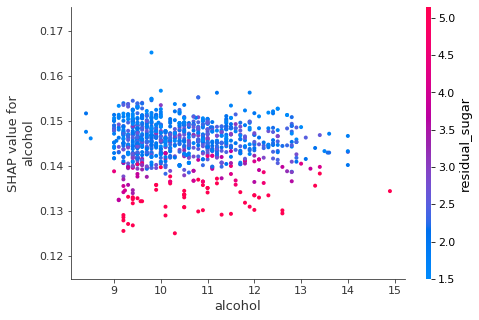

In [11]:
ivar = 10
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(classifier_variables[ivar], shap_values[1], Xtrain,
                     feature_names=classifier_variables)


# Importância (enxame)

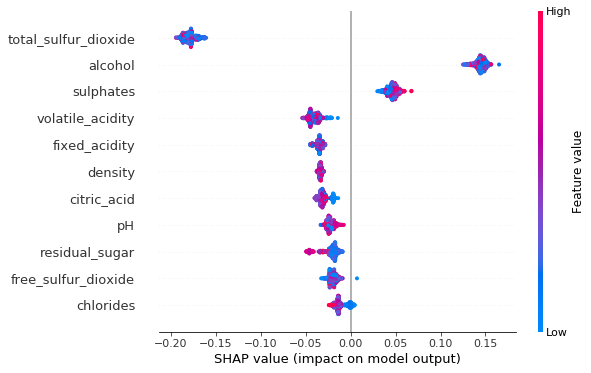

In [12]:
# summarize the effects of all the features
shap.summary_plot(shap_values[1], Xtrain, feature_names=classifier_variables)

# Importância Sumarizada 

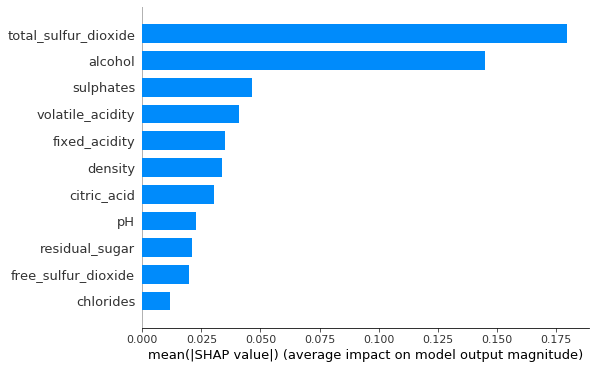

In [13]:
shap_values = explainer.shap_values(Xtrain)
shap.summary_plot(shap_values[1], Xtrain, feature_names=classifier_variables,  plot_type="bar")

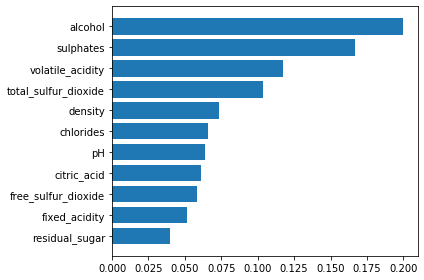

In [14]:
obj = model_pipe.best_estimator_.steps[1][1]
obj.feature_importances_

idx = obj.feature_importances_.argsort()
plt.barh(np.arange(obj.feature_importances_.shape[0]), obj.feature_importances_[idx])
plt.yticks(np.arange(obj.feature_importances_.shape[0]), np.array(classifier_variables)[idx])
plt.tight_layout()